In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score 

import xgboost
from xgboost import XGBClassifier

import imblearn
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

## label 균형 맞추기 처리

In [3]:
train = pd.read_csv("../data/240524/hr_teacher_train_scaling.csv")
test = pd.read_csv("../data/240524/hr_teacher_test_scaling.csv")

In [4]:
x_train = train.drop(columns=["attrition"]).values
y_train = train["attrition"].values

x_test = test.drop(columns=["attrition"]).values
y_test = test["attrition"].values

### sampling

In [5]:
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
x_enn, y_enn = enn.fit_resample(x_train,y_train)
np.unique(y_enn, return_counts=True)

(array([0, 1], dtype=int64), array([381, 175], dtype=int64))

In [6]:
smo = SMOTE(random_state=0)
x_smo, y_smo = smo.fit_resample(x_train,y_train)
np.unique(y_smo, return_counts=True)

(array([0, 1], dtype=int64), array([919, 919], dtype=int64))

In [7]:
smoeen = SMOTEENN(random_state=0)
x_smoeen, y_smoeen = smoeen.fit_resample(x_train,y_train)
np.unique(y_smoeen, return_counts=True)

(array([0, 1], dtype=int64), array([190, 422], dtype=int64))

### model

In [8]:
tree=DecisionTreeClassifier(random_state=42)
tree.fit(x_train,y_train)
pred_tree = tree.predict(x_test)
accuracy_score(pred_tree,y_test)

0.7342465753424657

In [9]:
tree_enn=DecisionTreeClassifier(random_state=42)
tree_enn.fit(x_enn,y_enn)
pred_enn = tree_enn.predict(x_test)
accuracy_score(pred_enn,y_test)

0.6109589041095891

In [10]:
tree_smo=DecisionTreeClassifier(random_state=42)
tree_smo.fit(x_smo,y_smo)
pred_smo = tree_smo.predict(x_test)
accuracy_score(pred_tree,y_test)

0.7342465753424657

In [11]:
tree_smoeen=DecisionTreeClassifier(random_state=42)
tree_smoeen.fit(x_smoeen,y_smoeen)
pred_smoeen = tree_smoeen.predict(x_test)
accuracy_score(pred_tree,y_test)

0.7342465753424657

In [12]:
print("리콜 origin",recall_score(y_pred=pred_tree, y_true=y_test))
print("리콜 enn",recall_score(y_pred=pred_enn, y_true=y_test))
print("리콜 smo",recall_score(y_pred=pred_smo, y_true=y_test))
print("리콜 smoenn",recall_score(y_pred=pred_smoeen, y_true=y_test))

리콜 origin 0.23728813559322035
리콜 enn 0.4067796610169492
리콜 smo 0.2542372881355932
리콜 smoenn 0.4406779661016949


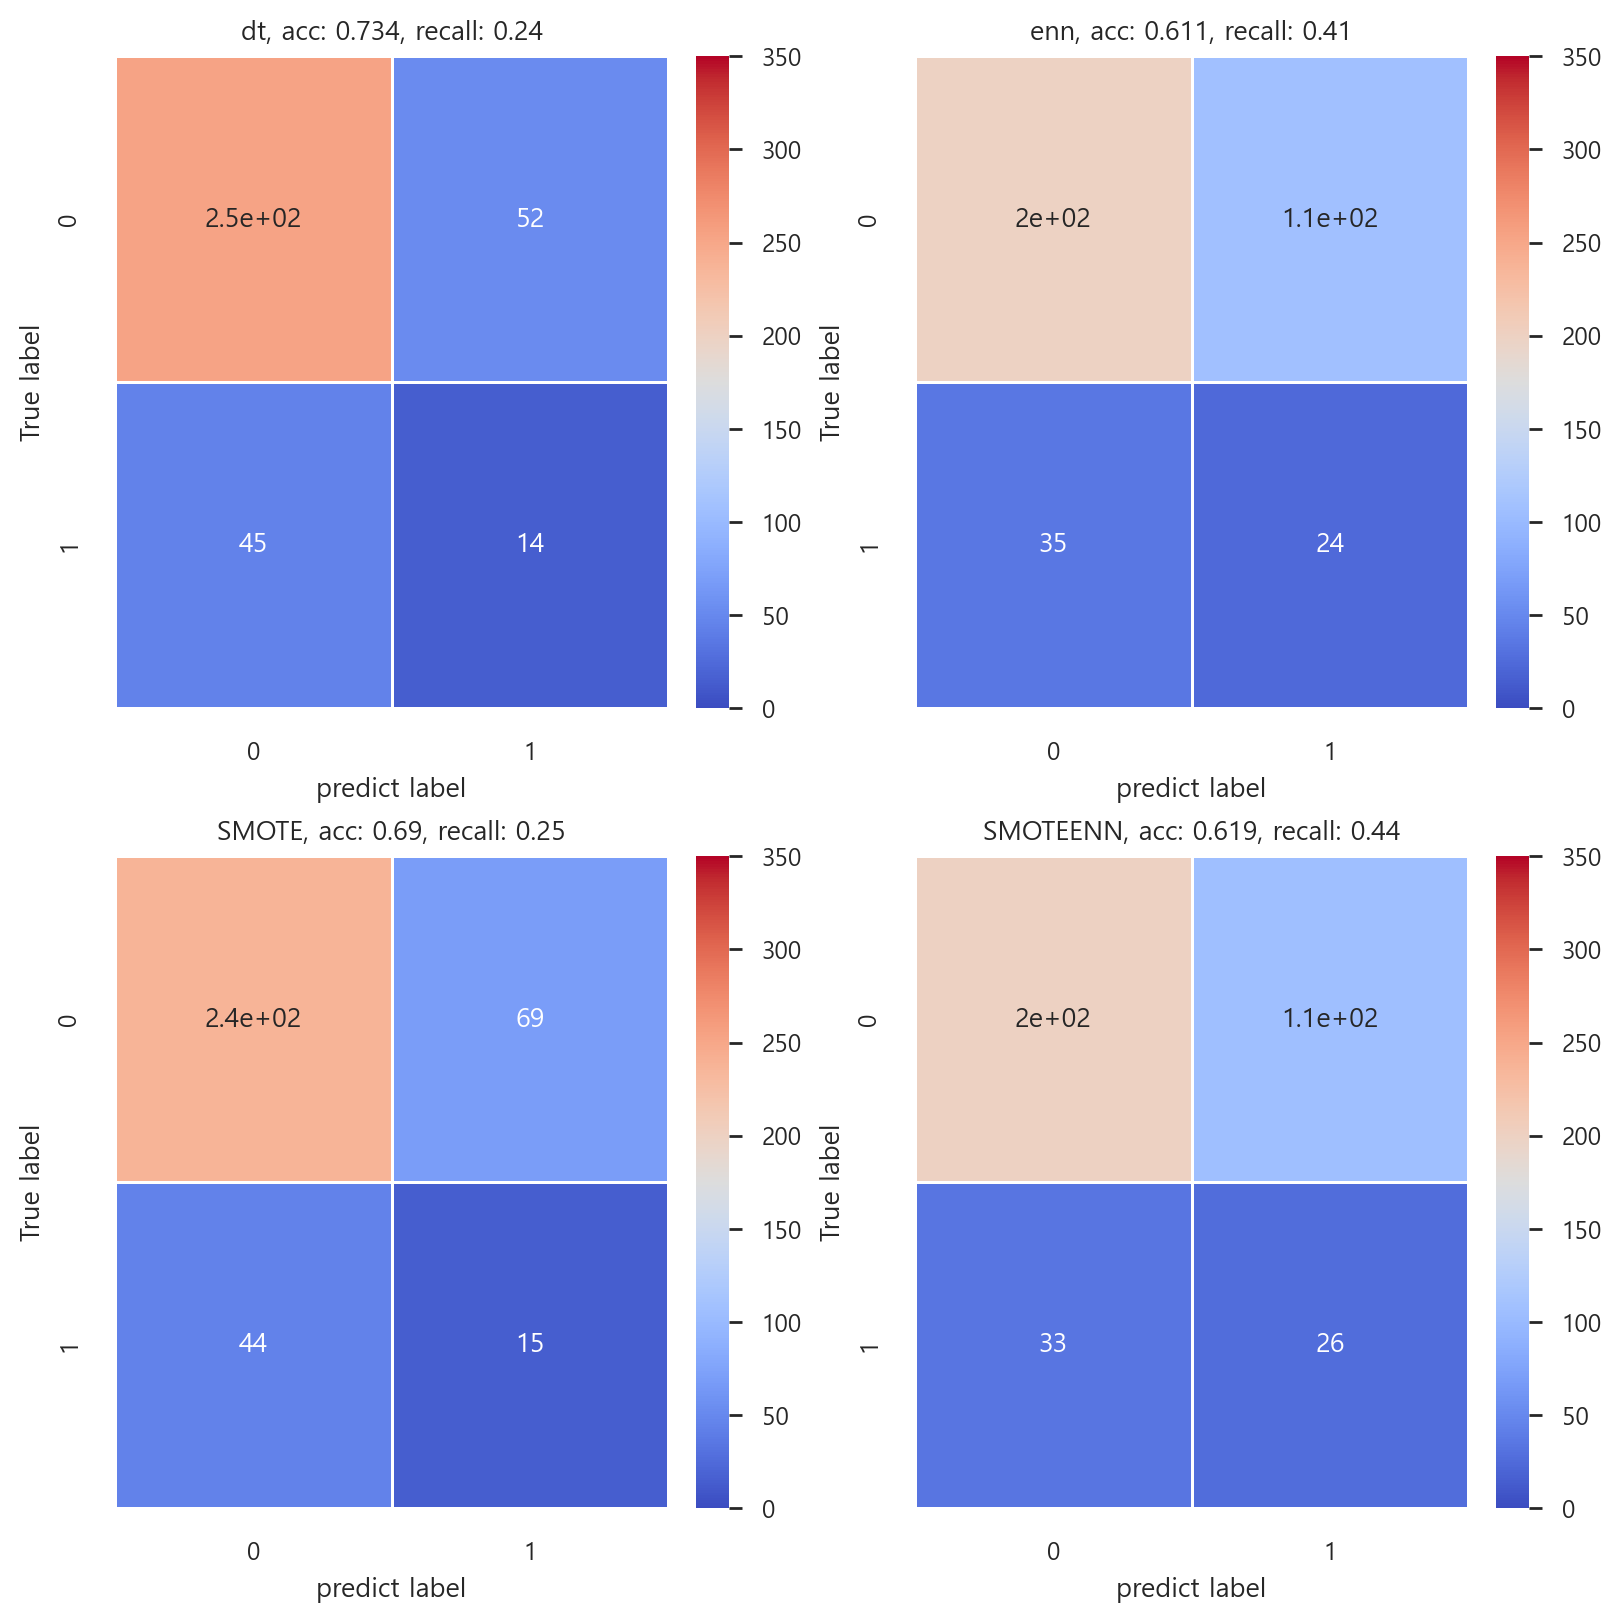

In [13]:
fig, ax = plt.subplots(2,2, figsize=(8,8))

pred_dict = {
    "dt"        : pred_tree,
    "enn"       : pred_enn,
    "SMOTE"     : pred_smo,
    "SMOTEENN"  : pred_smoeen,
}

for name, ax in zip (pred_dict.keys(), ax.flat):
    matrix = pred_dict[name]
    acc = round(accuracy_score(matrix, y_test), 3)
    recall = round(recall_score(y_test,pred_dict[name]),2)
    sns.heatmap(data = confusion_matrix(y_test, matrix),
                cmap="coolwarm",
                linecolor="white",
                linewidths=1,
                annot=True,
                vmax=350, #테스트 데이터의 개수가 114개 여서
                vmin=0,
                ax=ax)
    title = f"{name}, acc: {acc}, recall: {recall}"
    ax.set(xlabel = "predict label", ylabel = "True label", title = title);

## AUC - ROC Curve

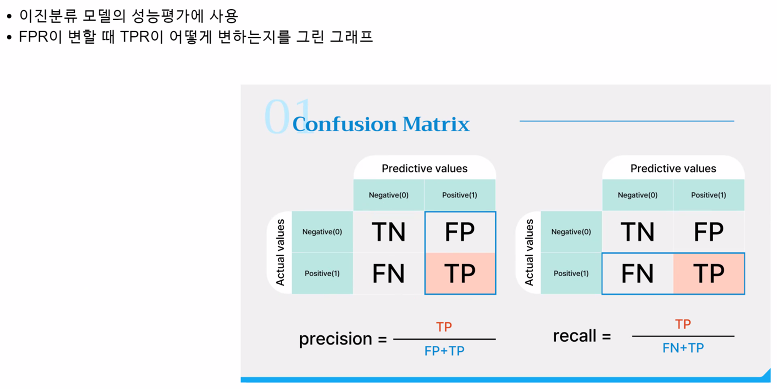

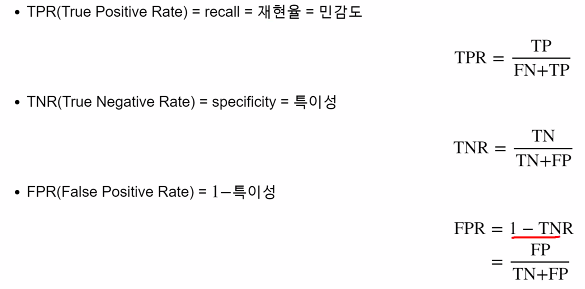

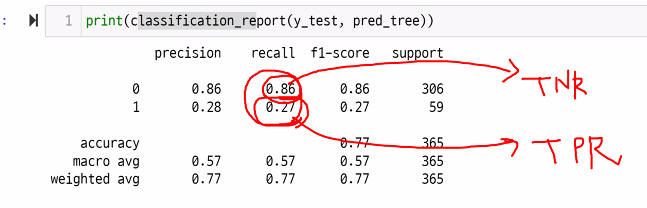

In [14]:
tree_fpr, tree_tpr, tree_thr = roc_curve(y_test, tree.predict_proba(x_test)[:,1])
tree_enn_fpr, tree_enn_tpr, tree_enn_thr = roc_curve(y_test, tree_enn.predict_proba(x_test)[:,1])

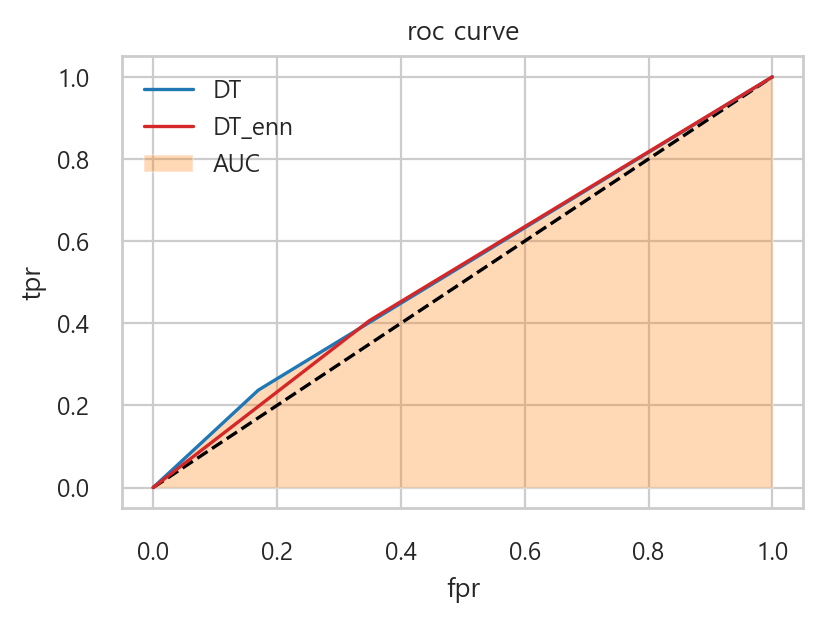

In [15]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0,1],[0,1],"k--")
ax.plot(tree_fpr,tree_tpr, label="DT", color = "tab:blue")
ax.plot(tree_enn_fpr,tree_enn_tpr, label="DT_enn", color = "tab:red")

ax.fill_between(tree_fpr,tree_tpr,facecolor="tab:orange",alpha=0.3, label="AUC")
ax.set(xlabel="fpr", ylabel="tpr", title="roc curve")
ax.legend();

In [16]:
print(roc_auc_score(y_test, tree.predict_proba(x_test)[:,1]))
print(roc_auc_score(y_test, tree_enn.predict_proba(x_test)[:,1]))

0.5336767475351722
0.528553229201285


##### 디테일한 설명

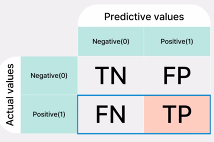

In [17]:
thr = 0.5
pred_thr = tree.predict_proba(x_test)[:,1]>thr

tn = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 0)])
fp = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 1)])
fn = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 0)])
tp = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 1)])

print("TPR:", tp/(fn+tp))
print("FPR:", fp/(tn+fp)) # 1 - TNR

TPR: 0.23728813559322035
FPR: 0.16993464052287582


In [18]:
tpr = [1]
fpr = [1]

for thr in np.arange(0, 1.1, 0.1): 
    pred_thr = tree.predict_proba(x_test)[:,1]>thr

    tn = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 0)])
    fp = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 1)])
    fn = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 0)])
    tp = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 1)])

    tpr.append(tp/(fn+tp))
    fpr.append(fp/(tn+fp)) # 1 - TNR

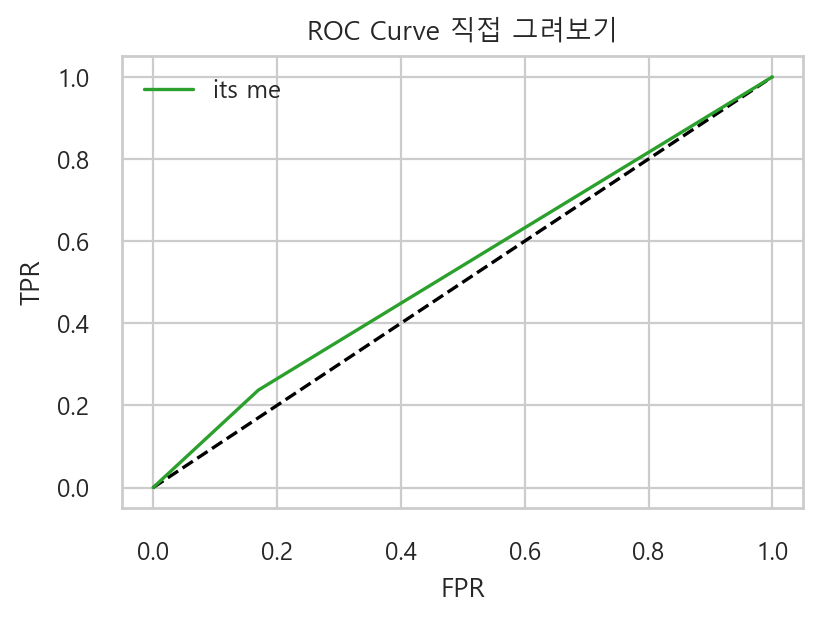

In [19]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0,1],[0,1],"k--")
ax.plot(fpr, tpr, label="its me", color = "tab:green")
ax.set(xlabel="FPR", ylabel="TPR", title="ROC Curve 직접 그려보기")
ax.legend();

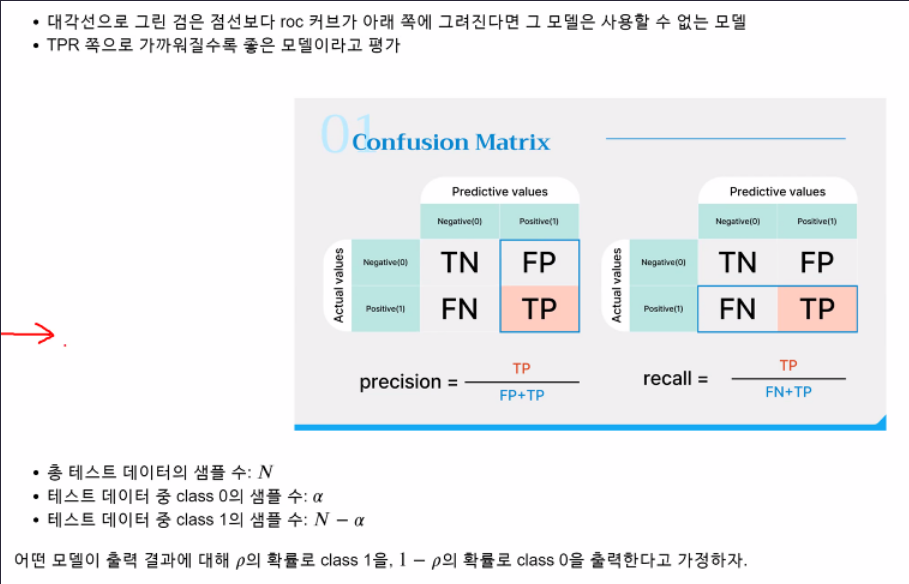

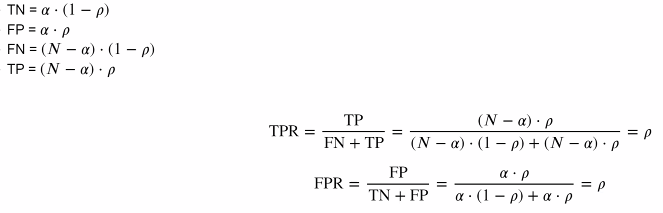

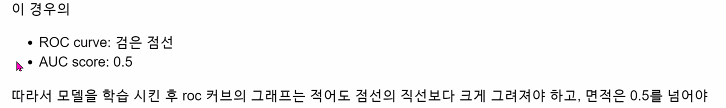